In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import PathPatch
import pingouin as pg

In [2]:
def load_data(file):
    df = pd.read_csv(file).reset_index(drop=True)
    df = df[df.stage.isin(conditions+baseline)]
    df.drop(columns=['name', 'task'], inplace=True)
    
    data = []
    for (pid, topic, stage) in df[['PID', 'Topic', 'stage']].value_counts().index:
        tt = df[(df.PID == pid) & (df.Topic == topic) & (df.stage == stage)]
        t = tt.mean(numeric_only=True).to_frame().transpose()
        t['PID'] = pid
        t['Topic'] = topic
        t['stage'] = stage
        data.append(t)
        
    df = pd.concat(data)
    df = df.reset_index(drop=True)
    print('--> Final Loaded Data:', df.shape)
    print(df.stage.value_counts())
    return df

In [3]:
conditions = ['IN', 'QF', 'QS', 'RJ', 'READ', 'LISTEN', 'SPEAK', 'TYPE']
baseline = ['EYEOPEN','EYECLOSE']
info_cols = ['stage', 'Topic', 'PID', 'name']
stats = []
postdoc_results = []

In [4]:
eoi = ['EYEOPEN', 'IN', 'QF', 'TYPE','SPEAK', 'LISTEN',  'READ', ]

colors = {'EYEOPEN':  '#00A0B0', 'BASELINE':  '#00A0B0', 'EYECLOSE':  '#00A0B0',
 'IN': '#59C4D4',
 'QF': '#cc333f',
 'QS': '#eb6841',
 'RJ': '#edc951',
 'READ': '#a58c38',
 'LISTEN': '#f2d985',
 'SPEAK': '#a4482d', 'TYPE': '#ef8666'}


boxprops={
    'palette': colors,
     'flierprops': {"marker": "x"},
    'boxprops': {"edgecolor": "white"},
     'medianprops':{"color": "white", "linewidth": 0},
    'showmeans': True, 'meanline': True, 'meanprops': {'color': 'white','ls': '--', 'lw': 1.5},
}


SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

#### EDA

In [5]:
df = load_data('data for analysis/EDA_features(2-1)_normed_baseline.csv')
df.head(3)

--> Final Loaded Data: (1215, 34)
stage
IN          235
QS          235
QF          235
TYPE        119
READ        118
LISTEN      117
SPEAK       116
EYEOPEN      20
EYECLOSE     20
Name: count, dtype: int64


,E4:EDA_mean,E4:EDA_median,E4:EDA_variance,E4:EDA_skewness,E4:EDA_kurtosis,E4:EDA_d1mean,E4:EDA_d2mean,E4:SCL_amp,E4:SCL_sd,E4:SCL_mean,...,E4:EDA_d1range,E4:EDA_d2max,E4:EDA_d2min,E4:EDA_d2sd,E4:EDA_d2range,E4:EDA_sd,E4:SCR_sd,PID,Topic,stage
0,-0.340792,-0.321257,0.023331,-0.179489,-0.037650,-0.002086,-0.001043,0.044944,-0.003730,-0.326518,...,-0.005207,-0.002664,-0.000060,-0.001137,-0.002604,-0.002666,-0.002346,PA29,355.0,READ
1,1.015387,0.980803,0.047384,0.970673,2.490388,0.003775,0.001887,-0.501382,0.000054,0.966711,...,0.003260,0.002800,0.001170,0.000649,0.001630,0.004155,0.004726,PA13,355.0,READ
2,-1.725860,-1.671260,0.046991,1.546627,-0.978748,0.004663,0.002331,0.264811,-0.008926,-1.641273,...,0.009458,0.004958,0.000229,0.001991,0.004729,0.006021,-0.006526,PA21,708.0,READ


In [6]:
df.columns

Index(['E4:EDA_mean', 'E4:EDA_median', 'E4:EDA_variance', 'E4:EDA_skewness',
       'E4:EDA_kurtosis', 'E4:EDA_d1mean', 'E4:EDA_d2mean', 'E4:SCL_amp',
       'E4:SCL_sd', 'E4:SCL_mean', 'E4:SCL_median', 'E4:SCL_max', 'E4:SCL_min',
       'E4:SCR_range', 'E4:SCR_max', 'E4:SCR_min', 'E4:SCR_mean', 'E4:EDA_max',
       'E4:EDA_min', 'E4:EDA_range', 'E4:SCL_range', 'E4:EDA_d1max',
       'E4:EDA_d1min', 'E4:EDA_d1sd', 'E4:EDA_d1range', 'E4:EDA_d2max',
       'E4:EDA_d2min', 'E4:EDA_d2sd', 'E4:EDA_d2range', 'E4:EDA_sd',
       'E4:SCR_sd', 'PID', 'Topic', 'stage'],
      dtype='object')

In [7]:
df[['stage', 'PID', 'Topic']][df.stage.isin(['READ', 'SPEAK', 'LISTEN', 'TYPE'])].groupby(['PID', 'Topic']).agg(lambda x: '-'.join(x))['stage'].value_counts()

stage
READ-TYPE       59
LISTEN-TYPE     58
LISTEN-SPEAK    58
READ-SPEAK      58
TYPE-LISTEN      1
TYPE-READ        1
Name: count, dtype: int64

In [8]:
for depvar in ['E4:EDA_mean', 'E4:SCL_mean', 'E4:SCR_mean']:
    print(depvar)
    d = pg.normality(data=df[df.stage.isin(eoi)], dv=depvar, group='stage')
    print(d)
    d = pg.homoscedasticity(data=df[df.stage.isin(eoi)], dv=depvar, group='stage')
    print(d)
    print('-'*10)

E4:EDA_mean
                W      pval  normal
stage                              
READ     0.981595  0.106087    True
IN       0.987840  0.043783   False
LISTEN   0.979004  0.063539    True
TYPE     0.975945  0.031183   False
SPEAK    0.982049  0.123360    True
EYEOPEN  0.957422  0.493727    True
QF       0.985433  0.016695   False
               W      pval  equal_var
levene  2.372996  0.027875      False
----------
E4:SCL_mean
                W          pval  normal
stage                                  
READ     0.975987  3.266395e-02   False
IN       0.995560  7.351115e-01    True
LISTEN   0.731145  2.404316e-13   False
TYPE     0.498818  2.278842e-18   False
SPEAK    0.619347  6.819990e-16   False
EYEOPEN  0.962435  5.935526e-01    True
QF       0.648354  9.322308e-22   False
               W      pval  equal_var
levene  2.919033  0.007947      False
----------
E4:SCR_mean
                W          pval  normal
stage                                  
READ     0.706236  4.72693

In [9]:
for depvar in ['E4:EDA_mean', 'E4:SCL_mean', 'E4:SCR_mean']:
    print(depvar)
    d = pg.friedman(data=df[df.stage.isin(eoi)], dv=depvar, within='stage', subject='PID', method='f')
    d['variable'] = depvar
    stats.append(d)
stats

E4:EDA_mean
E4:SCL_mean
E4:SCR_mean


[         Source      W  ddof1  ddof2         F     p-unc     variable
 Friedman  stage  0.065    5.9  112.1  1.320856  0.254372  E4:EDA_mean,
          Source         W  ddof1  ddof2         F     p-unc     variable
 Friedman  stage  0.061429    5.9  112.1  1.243531  0.290045  E4:SCL_mean,
          Source         W  ddof1  ddof2         F     p-unc     variable
 Friedman  stage  0.216786    5.9  112.1  5.259006  0.000091  E4:SCR_mean]

In [10]:
for depvar in ['E4:EDA_mean', 'E4:SCL_mean', 'E4:SCR_mean']:
    d = pg.pairwise_tests(data=df[df.stage.isin(eoi)], dv=depvar, within='stage', subject='PID', parametric=False, 
                          padjust='bonf', correction=True)
    d['variable'] = depvar
    postdoc_results.append(d)
postdoc_results

[   Contrast        A       B  Paired  Parametric  W-val alternative     p-unc  \
 0     stage  EYEOPEN      IN    True       False   72.0   two-sided  0.230513   
 1     stage  EYEOPEN  LISTEN    True       False   71.0   two-sided  0.216167   
 2     stage  EYEOPEN      QF    True       False   74.0   two-sided  0.261099   
 3     stage  EYEOPEN    READ    True       False   72.0   two-sided  0.230513   
 4     stage  EYEOPEN   SPEAK    True       False   72.0   two-sided  0.230513   
 5     stage  EYEOPEN    TYPE    True       False   70.0   two-sided  0.202450   
 6     stage       IN  LISTEN    True       False   74.0   two-sided  0.261099   
 7     stage       IN      QF    True       False   78.0   two-sided  0.329983   
 8     stage       IN    READ    True       False   68.0   two-sided  0.176853   
 9     stage       IN   SPEAK    True       False   90.0   two-sided  0.595819   
 10    stage       IN    TYPE    True       False   70.0   two-sided  0.202450   
 11    stage   L

In [11]:
df = load_data('data for analysis/ACC_features(2-1)_normed_baseline.csv')#../trainning data/EDA_features_combined_mergedtw.csv')
df.head(3)

--> Final Loaded Data: (1450, 8)
stage
RJ          235
IN          235
QS          235
QF          235
TYPE        119
READ        118
LISTEN      117
SPEAK       116
EYEOPEN      20
EYECLOSE     20
Name: count, dtype: int64


,E4:ACC_mean,E4:ACC_sd,E4:ACC_range,E4:ACC_max,E4:ACC_min,PID,Topic,stage
0,-0.674857,-0.198772,-0.198321,-0.414568,-0.040414,PA29,355.0,RJ
1,-0.674857,-0.198772,-0.198321,-0.414568,-0.040414,PA29,355.0,READ
2,0.224867,0.185434,0.197519,0.288849,-0.035573,PA13,355.0,RJ


In [12]:
d = pg.normality(data=df[df.stage.isin(eoi)], dv='E4:ACC_mean', group='stage')
print(d)
d = pg.homoscedasticity(data=df[df.stage.isin(eoi)], dv='E4:ACC_mean', group='stage')
print(d)
print('-'*10)

                W      pval  normal
stage                              
READ     0.994744  0.940328    True
IN       0.994816  0.606027    True
LISTEN   0.987580  0.362810    True
TYPE     0.924687  0.000005   False
SPEAK    0.991325  0.680108    True
EYEOPEN  0.970265  0.760452    True
QF       0.992882  0.320501    True
               W      pval  equal_var
levene  2.347628  0.029503      False
----------


In [26]:
d = pg.friedman(data=df[df.stage.isin(eoi)], dv='E4:ACC_mean', within='stage', subject='PID', method='f')
d['variable']='E4:ACC_mean'
print(d.round(3))
stats.append(d)

         Source    W  ddof1  ddof2      F  p-unc     variable
Friedman  stage  0.2    5.9  112.1  4.761    0.0  E4:ACC_mean


In [27]:
d = pg.pairwise_tests(data=df[df.stage.isin(eoi)], dv='E4:ACC_mean', within='stage', subject='PID', parametric=False,
                         padjust='bonf', correction=True)
d['variable']='E4:ACC_mean'
postdoc_results.append(d)

#### PUPIL

In [13]:
df = load_data('data for analysis/PUPIL_features(2-1)_normed_baseline.csv')
df.dropna(inplace=True)
df = df[df.stage.isin(eoi)]
df

--> Final Loaded Data: (1068, 29)
stage
IN         211
QS         210
QF         210
TYPE       107
READ       106
LISTEN     103
SPEAK      103
EYEOPEN     18
Name: count, dtype: int64


,PUPIL_median,PUPIL_max,PUPIL_min,PUPIL_mean,PUPIL_std,PUPIL_range,nblink,PUPIL_mean_RPD,PUPIL_max_RPD,PUPIL_min_RPD,...,PUPIL_min_RPDG,PUPIL_std_RPDG,PUPIL_range_RPDG,PUPIL_pcl25_RPDG,PUPIL_pcl50_RPDG,PUPIL_pcl75_RPDG,PUPIL_lhipa,PID,Topic,stage
0,0.118413,0.104513,0.116313,0.116636,-0.001670,-0.011800,-0.095849,0.045913,0.041141,0.045786,...,0.000355,-0.000152,-0.000207,0.000322,0.000024,-0.000216,-1.820290,PA29,355.0,READ
1,-0.245156,-0.307710,-0.209105,-0.251779,-0.029048,-0.098605,0.141522,-0.086858,-0.106153,-0.072136,...,0.007939,-0.003065,-0.013467,0.001619,-0.000056,-0.000670,-2.078616,PA13,355.0,READ
2,-0.267912,-0.348860,-0.201107,-0.274706,-0.046305,-0.147754,0.166667,-0.096046,-0.121973,-0.070313,...,0.013438,-0.006182,-0.028087,0.003769,0.000442,-0.001954,-2.343168,PA19,743.0,READ
3,0.072197,0.030276,0.025652,0.058438,-0.001510,0.004625,0.213534,0.020160,0.010445,0.008849,...,-0.006857,0.003235,0.015968,0.000332,-0.000247,0.000796,-2.170290,PA13,433.0,IN
4,-0.206149,-0.278689,-0.181620,-0.220906,-0.040948,-0.097069,0.200752,-0.077701,-0.098026,-0.063883,...,0.000972,-0.000322,0.000618,0.001904,0.000502,-0.000291,-1.576190,PA21,708.0,READ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,-0.170122,-0.257550,-0.108088,-0.175620,-0.049829,-0.149462,-0.357143,-0.061772,-0.090590,-0.038019,...,0.006275,0.000288,-0.001641,0.011871,0.008648,0.005776,-4.933333,PA21,419.0,QF
1063,-0.008924,0.228439,-0.082116,-0.019192,0.078650,0.310554,0.285714,-0.005891,0.070117,-0.025205,...,-0.005188,0.050703,0.125946,-0.030148,-0.027480,0.001118,-5.428571,PA18,433.0,LISTEN
1064,-0.121358,-0.155022,-0.077498,-0.118657,-0.024296,-0.077524,0.571429,-0.038562,-0.050380,-0.025186,...,0.000429,0.002397,0.008532,-0.002876,-0.005380,-0.003664,-5.266667,PA11,419.0,QF
1066,0.578446,1.982009,0.266640,0.853033,0.622471,1.715369,-0.357143,0.330638,0.768232,0.103350,...,-0.070391,0.071791,0.337766,-0.062662,-0.030918,-0.013539,-5.642857,PA12,353.0,TYPE


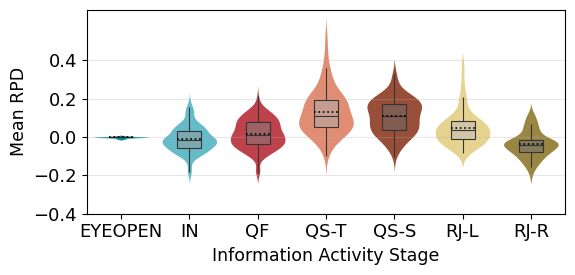

In [14]:
output = 1
xticks = ['EYEOPEN', 'IN', 'QF',  'QS-T', 'QS-S',  'RJ-L', 'RJ-R',]
_, ax = plt.subplots(figsize=(6, 3))
ax = sns.violinplot(data=df[df.stage.isin(eoi)], x='stage', y='PUPIL_mean_RPD', hue='stage', inner=None, \
                    linewidth=0, saturation=0.8,  palette=colors, order=eoi,)
sns.boxplot(data=df[df.stage.isin(eoi)], x='stage', y='PUPIL_mean_RPD', hue='stage', saturation=0.4, showcaps=False,
                     palette=colors, width=0.35, linewidth=0.8, showfliers=False, boxprops={'zorder': 2,},\
            ax=ax, **{'showmeans': True, 'meanline': True, 'meanprops': {'color': 'black','ls': ':', 'lw': 1.2}},order=eoi,)
ax.set_xticks(eoi, labels=xticks)
ax.set_yticks(np.arange(-0.4, 0.5, 0.2))
ax.grid(axis='y', alpha=0.3)
ax.set_ylabel('Mean RPD', size='small')
ax.set_xlabel('Information Activity Stage', size='small')
plt.tight_layout()
if output:
    plt.savefig('images/RPD_box.pdf', bbox_inches='tight')
plt.show()

In [15]:
d = pg.friedman(data=df[df.stage.isin(eoi)], dv='PUPIL_mean_RPD', within='stage', subject='PID', method='f')
d['variable']='PUPIL_mean_RPD'
print(d.round(3))
stats.append(d)

         Source      W  ddof1    ddof2       F  p-unc        variable
Friedman  stage  0.691  5.889  100.111  37.962    0.0  PUPIL_mean_RPD


In [16]:
d = pg.pairwise_tests(data=df[df.stage.isin(eoi)], dv='PUPIL_mean_RPD', within='stage', subject='PID', parametric=False,
                         padjust='bonf', correction=True)
d['variable']='PUPIL_mean_RPD'
postdoc_results.append(d)

#### export results to csv

In [17]:
stats = pd.concat(stats)
postdoc_results = pd.concat(postdoc_results)

In [18]:
stats

,Source,W,ddof1,ddof2,F,p-unc,variable
Friedman,stage,0.065000,5.900000,112.100000,1.320856,2.543722e-01,E4:EDA_mean
Friedman,stage,0.061429,5.900000,112.100000,1.243531,2.900452e-01,E4:SCL_mean
Friedman,stage,0.216786,5.900000,112.100000,5.259006,9.143748e-05,E4:SCR_mean
Friedman,stage,0.690697,5.888889,100.111111,37.962224,1.720784e-23,PUPIL_mean_RPD


In [19]:
postdoc_results

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges,variable
0,stage,EYEOPEN,IN,True,False,72.0,two-sided,0.230513,1.000000,bonf,-0.545541,E4:EDA_mean
1,stage,EYEOPEN,LISTEN,True,False,71.0,two-sided,0.216167,1.000000,bonf,-0.612740,E4:EDA_mean
2,stage,EYEOPEN,QF,True,False,74.0,two-sided,0.261099,1.000000,bonf,-0.485900,E4:EDA_mean
3,stage,EYEOPEN,READ,True,False,72.0,two-sided,0.230513,1.000000,bonf,-0.592157,E4:EDA_mean
4,stage,EYEOPEN,SPEAK,True,False,72.0,two-sided,0.230513,1.000000,bonf,-0.548530,E4:EDA_mean
...,...,...,...,...,...,...,...,...,...,...,...,...
16,stage,QF,SPEAK,True,False,0.0,two-sided,0.000008,0.000160,bonf,-1.233366,PUPIL_mean_RPD
17,stage,QF,TYPE,True,False,3.0,two-sided,0.000038,0.000801,bonf,-1.271162,PUPIL_mean_RPD
18,stage,READ,SPEAK,True,False,0.0,two-sided,0.000008,0.000160,bonf,-1.985067,PUPIL_mean_RPD
19,stage,READ,TYPE,True,False,0.0,two-sided,0.000008,0.000160,bonf,-1.893887,PUPIL_mean_RPD


In [20]:
if 'EYECLOSE' in eoi:
    stats.to_csv('results/periphs_stats_results_6stages_withEC.csv', index=False)
    postdoc_results.to_csv('results/periphs_postdoc_results_6stages_withEC.csv', index=False)
else:
    stats.to_csv('results/periphs_stats_results_6stages.csv', index=False)
    postdoc_results.to_csv('results/periphs_postdoc_results_6stages.csv', index=False)

#### plot pupil dilation

In [182]:
df = pd.read_csv('data for analysis/PUPIL_features_1s.csv', index_col=0).reset_index(drop=True)#../trainning data/EDA_features_combined_mergedtw.csv')
df = df[~df.PID.isin(['PA2', 'PA3', 'PA4'])]
df.replace({'SR': 'RJ'}, inplace=True)
df, plist = remove_data(df)
df = df[df.stage.isin(conditions+baseline)]

df = df.reset_index(drop=True)
print('--> Final Loaded Data:', df.shape)
print(df.stage.value_counts())

Data to Remove [('PA11', '353.0'), ('PA13', '419.0'), ('PA23', '433.0'), ('PA23', '725.0'), ('PA26', '433.0'), ('PA26', '448.0'), ('PA26', '416.0')]
-> Before (52862, 16)
1143 should droped
--> after remove unwanted data (51719, 16) from 27 Participants
['PA5' 'PA6' 'PA7' 'PA8' 'PA9' 'PA10' 'PA11' 'PA12' 'PA13' 'PA14' 'PA15'
 'PA16' 'PA17' 'PA18' 'PA19' 'PA21' 'PA22' 'PA23' 'PA24' 'PA25' 'PA26'
 'PA27' 'PA28' 'PA29' 'PA30' 'PA31' 'PA32']
--> Final Loaded Data: (51719, 16)
stage
RJ         16751
LISTEN      8576
READ        8063
IN          7540
QS          4155
QF          3055
TYPE        2162
SPEAK       1012
EYEOPEN      405
Name: count, dtype: int64


In [210]:
dd = df[['PUPIL_mean_RPD', 'n', 'task', 'stage', 'Topic', 'PID']]
dd = dd[dd.stage.isin(['EYEOPEN', 'IN', 'READ'])].reset_index(drop=True)
dd

,PUPIL_mean_RPD,n,task,stage,Topic,PID
0,0.022367,1,1,IN,433.0,PA5
1,-0.015382,2,1,IN,433.0,PA5
2,-0.071987,3,1,IN,433.0,PA5
3,-0.046258,4,1,IN,433.0,PA5
4,-0.079349,5,1,IN,433.0,PA5
...,...,...,...,...,...,...
16003,0.031943,11,Baseline,EYEOPEN,Baseline,PA32
16004,-0.005020,12,Baseline,EYEOPEN,Baseline,PA32
16005,-0.034943,13,Baseline,EYEOPEN,Baseline,PA32
16006,-0.002286,14,Baseline,EYEOPEN,Baseline,PA32


In [184]:
groups = list(dd[['PID', 'task', 'stage']].value_counts().index)
pupildf = []
nwindow = 3
for group in groups:
    temp = dd[(dd.PID == group[0]) & (dd.task == group[1]) & (dd.stage == group[2])].sort_values(by='n')
    interval = int(np.around(len(temp)/nwindow, decimals=0))
    tt = temp['PUPIL_mean_RPD'].values
    res = []
    wsize = []
    prev = 0
    for n in range(nwindow):
        n = prev+interval
        if n == nwindow-1:
            res.append(np.mean(tt[prev:]))
            wsize.append(len(tt[prev:]))
        else:
            res.append(np.mean(tt[prev:n]))
            wsize.append(len(tt[prev:n]))
        prev = n
        
    tdf = pd.DataFrame([res, np.arange(nwindow)+1, wsize, np.repeat(len(temp), nwindow),\
                            np.repeat(group[0], nwindow), np.repeat(group[1], nwindow), np.repeat(group[2], nwindow)], 
                          index=['PUPIL_mean_RPD', 'n', 'win_size', 'total', 'PID', 'task', 'stage']).transpose()
    pupildf.append(tdf)
pupildf = pd.concat(pupildf).reset_index(drop=True)
print(pupildf)

     PUPIL_mean_RPD  n win_size total   PID task stage
0         -0.021898  1       43   130  PA10   10  READ
1         -0.053431  2       43   130  PA10   10  READ
2          -0.06984  3       43   130  PA10   10  READ
3         -0.042124  1       39   118  PA29    5  READ
4         -0.065635  2       39   118  PA29    5  READ
...             ... ..      ...   ...   ...  ...   ...
1504      -0.057056  2        2     7   PA5   11    IN
1505      -0.087152  3        2     7   PA5   11    IN
1506       0.008565  1        6     6  PA31    9    IN
1507       0.024996  2        2     6  PA31    9    IN
1508       0.028573  3        2     6  PA31    9    IN

[1509 rows x 7 columns]


In [185]:
pupildf.dropna(inplace=True)
pupildf

,PUPIL_mean_RPD,n,win_size,total,PID,task,stage
0,-0.021898,1,43,130,PA10,10,READ
1,-0.053431,2,43,130,PA10,10,READ
2,-0.06984,3,43,130,PA10,10,READ
3,-0.042124,1,39,118,PA29,5,READ
4,-0.065635,2,39,118,PA29,5,READ
...,...,...,...,...,...,...,...
1504,-0.057056,2,2,7,PA5,11,IN
1505,-0.087152,3,2,7,PA5,11,IN
1506,0.008565,1,6,6,PA31,9,IN
1507,0.024996,2,2,6,PA31,9,IN


In [186]:
pupildf[['stage', 'win_size', 'total']].groupby('stage').mean()

,win_size,total
stage,,
EYEOPEN,5.0,15.0
IN,7.839662,23.765823
READ,16.726115,50.541401


In [205]:
pupildf['stage'] = pupildf['stage'].apply(lambda x: {'EYEOPEN': 'EYEOPEN', 'IN':'IN', 'READ': 'RJ-READ', 'RJ-READ':'RJ-READ'}.get(x))
pupildf

,PUPIL_mean_RPD,n,win_size,total,PID,task,stage
0,-0.021898,1,43,130,PA10,10,RJ-READ
1,-0.053431,2,43,130,PA10,10,RJ-READ
2,-0.06984,3,43,130,PA10,10,RJ-READ
3,-0.042124,1,39,118,PA29,5,RJ-READ
4,-0.065635,2,39,118,PA29,5,RJ-READ
...,...,...,...,...,...,...,...
1504,-0.057056,2,2,7,PA5,11,IN
1505,-0.087152,3,2,7,PA5,11,IN
1506,0.008565,1,6,6,PA31,9,IN
1507,0.024996,2,2,6,PA31,9,IN


In [211]:
dd = dd[dd.n <= 14]
dd['stage'] = dd['stage'].apply(lambda x: {'EYEOPEN': 'EYEOPEN', 'IN':'IN', 'READ': 'RJ-READ', 'RJ-READ':'RJ-READ'}.get(x))
dd

/tmp/ipykernel_4507/3901676625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['stage'] = dd['stage'].apply(lambda x: {'EYEOPEN': 'EYEOPEN', 'IN':'IN', 'READ': 'RJ-READ', 'RJ-READ':'RJ-READ'}.get(x))


,PUPIL_mean_RPD,n,task,stage,Topic,PID
0,0.022367,1,1,IN,433.0,PA5
1,-0.015382,2,1,IN,433.0,PA5
2,-0.071987,3,1,IN,433.0,PA5
3,-0.046258,4,1,IN,433.0,PA5
4,-0.079349,5,1,IN,433.0,PA5
...,...,...,...,...,...,...
16002,0.035695,10,Baseline,EYEOPEN,Baseline,PA32
16003,0.031943,11,Baseline,EYEOPEN,Baseline,PA32
16004,-0.005020,12,Baseline,EYEOPEN,Baseline,PA32
16005,-0.034943,13,Baseline,EYEOPEN,Baseline,PA32


In [212]:
dd[dd.stage == 'EYEOPEN'].n.max()

14

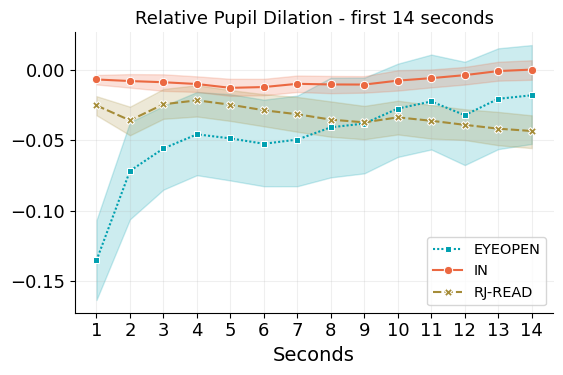

In [219]:
output = 1
_, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data=dd, hue='stage', x='n', y='PUPIL_mean_RPD', hue_order=['EYEOPEN', 'IN', 'RJ-READ'], markers=True, style='stage',
             errorbar=("ci", 95), palette={'EYEOPEN': '#00A0B0','IN': '#eb6841', 'RJ-READ': '#a58c38',}, )
ax.set_title('Relative Pupil Dilation - first 14 seconds', fontsize=13)
ax.set_ylabel(None)
ax.set_xlabel('Seconds', fontsize=14)
ax.set_xticks(np.arange(1, 15))
ax.legend(loc='lower right', fontsize='x-small')
ax.grid(alpha=0.2)
sns.despine(ax=ax, top=True, right=True)
plt.tight_layout()
if output:
    plt.savefig('../images/RPD_3line.pdf', bbox_inches='tight')
plt.show()